In [1]:
%matplotlib widget

In [103]:
#!/usr/bin/env python
import os
import sys
import h5py
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import pyproj
from datetime import datetime
from osgeo import gdal, gdalconst, osr
from utils import interp2d

from osgeo import gdal, gdalconst, osr
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, Polygon
from descartes.patch import PolygonPatch
from matplotlib import path, patches

plt.ticklabel_format(useOffset=False)

#data_dir='ATL06/Byrd_glacier_rel001/'

lon_lat=pyproj.Proj(init='epsg:4326')
polar_stereo=pyproj.Proj(init='epsg:3031')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# make sure we're dealing with the most recent version of any code we're using
#%load_ext autoreload
#%autoreload 2


def ATL06_to_dict(filename, dataset_dict, gpstime=True):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            gpstime: boolean; correct times for GPS epoch (default true)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a list of numpy arrays containing the 
                data
    """
    
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']
    gps_epoch = datetime(1980, 1, 6, 0, 0, 0)
    gps_epoch_ts = gps_epoch.timestamp()
    # open the HDF5 file
    with h5py.File(filename) as h5f:
        if gpstime: #calc the time offset to unix time
            file_epoch_time = np.array(h5f['ancillary_data']['atlas_sdp_gps_epoch']) + gps_epoch_ts
        else:
            file_epoch_time = 0
        
        # loop over beam pairs
        for pair in pairs:
            # loop over beams
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                # loop over the groups in the dataset dictionary
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # since a dataset may not exist in a file, we're going to try to read it, and if it doesn't work, we'll move on to the next:
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            if dataset == "delta_time":
                                temp[dataset] = temp[dataset] + file_epoch_time
                            # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                bad = temp[dataset] == fill_value
                                temp[dataset] = np.float64(temp[dataset])
                                temp[dataset][temp[dataset]==fill_value]=np.NaN
                        except KeyError as e:
                            pass
                if len(temp) > 0:
                    # it's sometimes convenient to have the beam and the pair as part of the output data structure: This is how we put them there.
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

def get_velocity(x, y, vx, vy, D6):
    psx,psy = pyproj.transform(lon_lat,polar_stereo,D6['longitude'],D6['latitude'])
    vel_x = interp2d(x, y, vx, psx, psy, order=1)
    vel_y = interp2d(x, y, vy, psx, psy, order=1)
    vdir = np.rad2deg(np.arctan2(vel_x, vel_y))%360.
    return vdir

def get_rema_elev(D6):
    psx,psy = pyproj.transform(lon_lat,polar_stereo,D6['longitude'],D6['latitude'])
    rema_is2 = interp2d(rema_xI, rema_yI, rema_array, psx, psy, order=1)
    return rema_is2
  
# this thang don't work, don't use it    
def load_tif(tif):
    dataset = gdal.Open(tif, gdal.GA_ReadOnly)
    band = dataset.GetRasterBand(1)
    array = band.ReadAsArray()
    proj=dataset.GetProjection()
    GT=dataset.GetGeoTransform()
    ii=np.array([0, band.XSize-1])+0.5
    jj=np.array([0,band.YSize])+0.5
    x=GT[0]+GT[1]*ii
    y=GT[0]+GT[1]*jj
    dx=GT[1]
    dy=(GT[5]*-1)
    xi=np.arange(x.min(),x.max()+dx,dx)
    yi=np.arange(y.min(),y.max()+dy,dy)
    xI, yI = np.meshgrid(xi, yi)
    return xI,yI,np.flipud(array) 

def tifread(ifile):
    file = gdal.Open(ifile, gdal.GA_ReadOnly)
    metaData = file.GetMetadata()
    projection = file.GetProjection()
    src = osr.SpatialReference()
    src.ImportFromWkt(projection)
    proj = src.ExportToWkt()

    Nx = file.RasterXSize
    Ny = file.RasterYSize
    
    trans = file.GetGeoTransform()

    dx = trans[1]
    dy = trans[5]

    Xp = np.arange(Nx)
    Yp = np.arange(Ny)

    (Xp, Yp) = np.meshgrid(Xp, Yp)

    X = trans[0] + (Xp + 0.5) * trans[1] + (Yp + 0.5) * trans[2]
    Y = trans[3] + (Xp + 0.5) * trans[4] + (Yp + 0.5) * trans[5]

    band = file.GetRasterBand(1)
    Z = band.ReadAsArray()
    dx = np.abs(dx)
    dy = np.abs(dy)
    return X, Y, Z

    
def findGL(D6):
    """Return array of indices of intersection of Grounding Zone and ATL06
       Return polygon of the GL
      """
    shapefile = gpd.read_file("./data/GL_VARIABILITY.shp")
    ## read the grounding line - which is a multi-polygon
    ## and find the largest polygon
    gl_fn = '/home/jovyan/IMBIE/GroundingLine_Antarctica_v02.shp'
    #imbie_gdf = gpd.read_file(imbie_fn)
    gl_gdf = gpd.read_file(gl_fn)
    geom0=gl_gdf['geometry'][0]
    len(geom0)
    areas = [i.area for i in geom0]
    largest = np.argmax(areas)
    polygon = geom0[largest]
    
#     for polygon in shapefile.geometry:
#        patch = PolygonPatch(polygon)
#        xp, yp = polygon.exterior.coords.xy
#        coords = np.squeeze(np.dstack((xp,yp)))
#        #plt.plot(*polygon.exterior.xy);
#     polygon = shapefile.geometry[0] # Item number can be changed for
    xp, yp = polygon.exterior.coords.xy
    coords = np.squeeze(np.dstack((xp,yp)))
    poly_mpl = path.Path(coords)
    temp = {}
    temp["x"],temp["y"] = pyproj.transform(lon_lat,polar_stereo,D6["longitude"],D6["latitude"])
    mask = poly_mpl.contains_points(np.transpose([temp["x"],temp["y"]]))
    #plt.plot(*polygon.exterior.xy)
    #plt.plot(temp[‘x’],temp[‘y’])
    cross=np.argwhere(mask)
    return cross, polygon
    

In [106]:
if __name__ == "__main__":

    # get h5 files, velocity files, and rema
    #os.system('aws --no-sign-request s3 sync s3://pangeo-data-upload-oregon/icesat2/ground2float/ ./data')
    #os.system('echo $PATH')
        
    #lineno=898
    #fn = "/home/jovyan/ground2float/data/ATL06/ATL06_20181208072425_10790110_001_01.h5" # file name for the line
    data_dir = "/home/jovyan/ground2float/data/ATL06/*01.h5"
    ATLfiles = glob(data_dir)
    #print(ATLfiles)
    
    fn = ATLfiles[0]
    
    fbase, ext = os.path.splitext(fn)
    ftide = fbase+"_tides_cats" + ext
    
    T6_list=[]
    with h5py.File(ftide) as tidef:
        trks = tidef.keys()
        for i, trk in enumerate(trks):
            tmp={}
            tmp["latitude"] = np.array(tidef[f"/{trk}/lat"]).T
            tmp["longitude"] = np.array(tidef[f"/{trk}/lon"]).T
            tmp["tide"] = np.array(tidef[f"/{trk}/tides_cats"]).T
            tmp["time"] = np.array(tidef[f"/{trk}/time"]).T

            T6_list.append(tmp)
            #print(trk, lat)
    #print(T6_list[0])          
    dataset_dict={'land_ice_segments':['h_li', 'delta_time','longitude','latitude'], 'land_ice_segments/ground_track':['x_atc']}
    # read ATL06 into a dictionary (the ATL06 file has the same name as the ATL03 file, except for the product name)
    
    fn = ATLfiles[0]
    D6_list=ATL06_to_dict(fn, dataset_dict)

    # pick out gt2r:
    D6 = D6_list[3]
    print(datetime.utcfromtimestamp(D6['delta_time'][0]))
    T6 = T6_list[3]

    print(D6['x_atc'].shape)
    print(T6['tide'].shape)
    crossing, poly = findGL(D6)
    print(crossing)
    
    
    plt.close('all')
    f1,ax = plt.subplots(4,1, figsize=(10,6), sharex=True)
    ax[0].plot(D6['x_atc'], D6['h_li'],'r.', markersize=2, label='ATL06')
    ax[0].plot(D6['x_atc'], T6['tide'])
    lgd = ax[0].legend(loc=3,frameon=False)
    ax[0].set_ylim([-100,100])
    ax[0].set_xlabel('x_atc, m')
    ax[0].set_ylabel('h, m')
    ax[0].title.set_text('ATL06 h_li & Padman Tide h')
    ax[0].axvline(D6['x_atc'][crossing[0]])
    ax[0].axvline(D6['x_atc'][crossing[-1]])
    #plt.savefig('thwt.png')
    
    # load in velocity and subsample
    vels_xI,vels_yI,vels_array_x=tifread('./data/vx.tif')
    vels_xI,vels_yI,vels_array_y=tifread('./data/vy.tif')

    vels = get_velocity(vels_xI, vels_yI, vels_array_x, vels_array_y, D6)
    #print(vels)
    #plt.plot(D6['x_atc'], vels ,'g.', markersize=2, label='Velocity')

    # load in rema and subsample
    rema_xI,rema_yI,rema_array=tifread('./data/REMA_1km_dem_filled.tif')
    rema_elev = get_rema_elev(D6)
    
    # plot results
    #f2,ax2 = plt.subplots(312, sharex=True, sharey=True)
    ax[1].plot(D6['x_atc'], D6['h_li'],'r.', markersize=2, label='ATL06')
    ax[1].plot(D6['x_atc'], rema_elev ,'b.', markersize=2, label='REMA')
    lgd = ax[1].legend(loc=3,frameon=False)
    ax[1].set_ylim([-100,2000])
    ax[1].set_xlabel('x_atc, m')
    ax[1].set_ylabel('h, m')
    ax[1].title.set_text('ATL06 h_li & REMA h')
    
    ax[1].axvline(D6['x_atc'][crossing[0]])
    ax[1].axvline(D6['x_atc'][crossing[-1]])
    #plt.savefig('thw0.png')
    
    #f3,ax3 = plt.subplots(313, sharex=True, sharey=True)
    ax[2].plot(D6['x_atc'], D6['h_li']-rema_elev,'r.', markersize=2, label='Difference IS2-REMA')
    lgd = ax[2].legend(loc=3,frameon=False)
    ax[2].set_ylim([-100,100])
    ax[2].set_xlabel('x_atc, m')
    ax[2].set_ylabel('h, m')
    ax[2].title.set_text('Difference IS2-REMA')
    
    ax[2].axvline(D6['x_atc'][crossing[0]])
    ax[2].axvline(D6['x_atc'][crossing[-1]])
    
    ax[3].plot(D6['x_atc'], vels ,'g.', markersize=2, label='Velocity')
    ax[3].title.set_text('GOLIVE Velocity aximuth')
    plt.tight_layout()
    

    ax[3].axvline(D6['x_atc'][crossing[0]])
    ax[3].axvline(D6['x_atc'][crossing[-1]])

    #plt.savefig('thw1.png')
    
    #gl_gdf = glread()
    #plot(gl_gdf[0])

2018-11-05 09:03:00.338078
(40162,)
(40162, 1)
[[18833]
 [18834]
 [18835]
 ...
 [40159]
 [40160]
 [40161]]


FigureCanvasNbAgg()

In [77]:
D6['x_atc'][18870]

28465725.190596685

In [15]:
gl

,TYPE,geometry
NAME,,
Grounded,GR,(POLYGON ((-217776.5323804202 2130382.52206734...


In [32]:
gl.plot()
plt.plot([0,0], [1000000, 1000000]);

FigureCanvasNbAgg()

In [18]:
gl

,TYPE,geometry
NAME,,
Grounded,GR,(POLYGON ((-217776.5323804202 2130382.52206734...


In [22]:
gm = gl.geometry
gm
#coords = np.squeeze(np.dstack((xp,yp)))

NAME
Grounded    (POLYGON ((-217776.5323804202 2130382.52206734...
Name: geometry, dtype: object

In [46]:
 rema_xI,rema_yI,rema_array=tifread('./data/REMA_1km_dem_filled.tif')

In [96]:
psx,psy = pyproj.transform(lon_lat,polar_stereo,D6['longitude'],D6['latitude'])

In [47]:
plt.imshow(rema_array)

In [97]:
ext = rema_xI[0][0], rema_xI[0][-1], rema_yI[-1][0], rema_yI[0][0]

In [102]:
plt.close('all')
plt.imshow(rema_array, extent=ext)
plt.plot(psx, psy)
plt.plot(*poly.exterior.xy)
    #plt.plot(temp[‘x’],temp[‘y’])

FigureCanvasNbAgg()

In [100]:
cross, poly = findGL(D6)

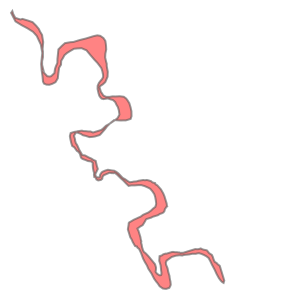

In [101]:
poly